<a href="https://colab.research.google.com/github/LEDazzio01/Simplest-Conformal-Prediction/blob/main/20250329-cpb-model-misspecification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conformal Prediction Basics: Model Misspecification

This notebook demonstrates how model misspecification can affect the performance of conformal prediction. We'll use a simple regression example where the underlying relationship is non-linear, but we'll fit both a linear and a non-linear model to highlight the differences. This will show how conformal prediction intervals can still provide valid coverage, but their efficiency (width) suffers under model misspecification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# 1. Generate Synthetic Data
This section generates synthetic data with a non-linear relationship.  The generate_data function creates data where the dependent variable y is a sinusoidal function of the independent variable X, with added noise. This simulates a real-world scenario where the relationship between variables is complex and not perfectly linear.

In [2]:
def generate_data(n_samples, noise_std=0.5):
    """Generates synthetic data with a non-linear relationship."""
    X = np.random.uniform(-5, 5, n_samples)
    y = np.sin(X) + np.random.normal(0, noise_std, n_samples)  # Non-linear relationship: y = sin(x) + noise
    X = X.reshape(-1, 1) # Make X a column vector
    return X, y

n_samples = 100
X, y = generate_data(n_samples)

# 2. Split Data into Training, Calibration, and Test Sets
Here, the generated data is split into three sets: training, calibration, and test sets. The training set is used to train the models. The calibration set is used to determine the nonconformity scores needed for conformal prediction. The test set is used to evaluate the performance of the conformal prediction intervals.

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_calibration, X_test, y_calibration, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 3. Fit a Linear Regression Model (Misspecified Model)
A linear regression model is trained on the training data.  Since the data was generated with a non-linear relationship, this model is misspecified.  We then make predictions on the test set using this misspecified model.

In [4]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# 4. Fit a Polynomial Regression Model (Correctly Specified Model)
A polynomial regression model is trained on the training data.  Because the data has a sinusoidal component, the polynomial regression model can capture the non-linearity, and is therefore a correctly specified model in this case. We use a 3rd degree polynomial here.

In [5]:
poly_features = PolynomialFeatures(degree=3)

X_train_poly = poly_features.fit_transform(X_train)
X_calibration_poly = poly_features.transform(X_calibration)
X_test_poly = poly_features.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)

# 5. Calculate Nonconformity Scores (Residuals) on the Calibration Set
The nonconformity scores, which measure how well each data point conforms to the model's predictions, are calculated on the calibration set for both the linear and polynomial regression models.  In this case, the absolute values of the residuals (the difference between the predicted and actual values) are used as the nonconformity scores.

In [6]:
calibration_predictions_linear = linear_model.predict(X_calibration)
nonconformity_scores_linear = np.abs(y_calibration - calibration_predictions_linear)

calibration_predictions_poly = poly_model.predict(X_calibration_poly)
nonconformity_scores_poly = np.abs(y_calibration - calibration_predictions_poly)

# 6. Define Conformal Prediction Function
This function, conformal_prediction, calculates the conformal prediction intervals.  It takes a model, calibration data, test data, pre-calculated nonconformity scores, and a significance level (alpha) as input.  It returns a list of prediction intervals (lower and upper bounds) for each test point.

In [7]:
def conformal_prediction(model, X_calibration, y_calibration, X_test, nonconformity_scores, alpha=0.1):
    sorted_scores = np.sort(nonconformity_scores)
    q_level = np.ceil((len(y_calibration) + 1) * (1 - alpha)) / len(y_calibration)
    # Handle the case where q_level might be slightly larger than 1 due to numerical issues
    q_level = min(q_level, 1.0)
    threshold = sorted_scores[int(np.floor((len(y_calibration)) * q_level)) - 1] # index starts at 0

    prediction_intervals = []
    for i, x in enumerate(X_test):
        # Need to handle polynomial features correctly
        if 'PolynomialFeatures' in str(model):
            x_transformed = poly_features.transform(x.reshape(1, -1))
            y_hat = model.predict(x_transformed)[0]
        else:
            x = x.reshape(1, -1)  # Ensure x is a row vector
            y_hat = model.predict(x)[0]
        lower_bound = y_hat - threshold
        upper_bound = y_hat + threshold
        prediction_intervals.append((lower_bound, upper_bound))
    return prediction_intervals

# 7. Generate Predictions and Intervals
This section generates the conformal prediction intervals for both the linear and polynomial regression models, using the conformal_prediction function defined in the previous step.

In [8]:
alpha = 0.1  # 90% confidence level
prediction_intervals_linear = conformal_prediction(linear_model, X_calibration, y_calibration, X_test, nonconformity_scores_linear, alpha)
prediction_intervals_poly = conformal_prediction(poly_model, X_calibration_poly, y_calibration, X_test_poly, nonconformity_scores_poly, alpha)

### Get point predictions for plotting

In [9]:
y_pred_test_linear = linear_model.predict(X_test)
y_pred_test_poly = poly_model.predict(X_test_poly)

# 8. Evaluate Coverage
The coverage of the conformal prediction intervals is evaluated.  The calculate_coverage function calculates the proportion of test points whose true values fall within the predicted intervals.  For a given significance level alpha, the coverage should be at least 1-alpha.

In [10]:
def calculate_coverage(prediction_intervals, y_test):
    """Calculates the empirical coverage of the prediction intervals."""
    covered = 0
    for i, (lower, upper) in enumerate(prediction_intervals):
        if lower <= y_test[i] <= upper:
            covered += 1
    return covered / len(y_test)

coverage_linear = calculate_coverage(prediction_intervals_linear, y_test)
coverage_poly = calculate_coverage(prediction_intervals_poly, y_test)
print(f"Linear Model Empirical Coverage: {coverage_linear:.3f}")
print(f"Polynomial Model Empirical Coverage: {coverage_poly:.3f}")

Linear Model Empirical Coverage: 0.900
Polynomial Model Empirical Coverage: 0.900


# 9. Visualize Results

The results are visualized to compare the performance of the conformal prediction intervals for the misspecified (linear) and correctly specified (polynomial) models.  The plot shows the training data, test data, the model predictions, and the conformal prediction intervals.

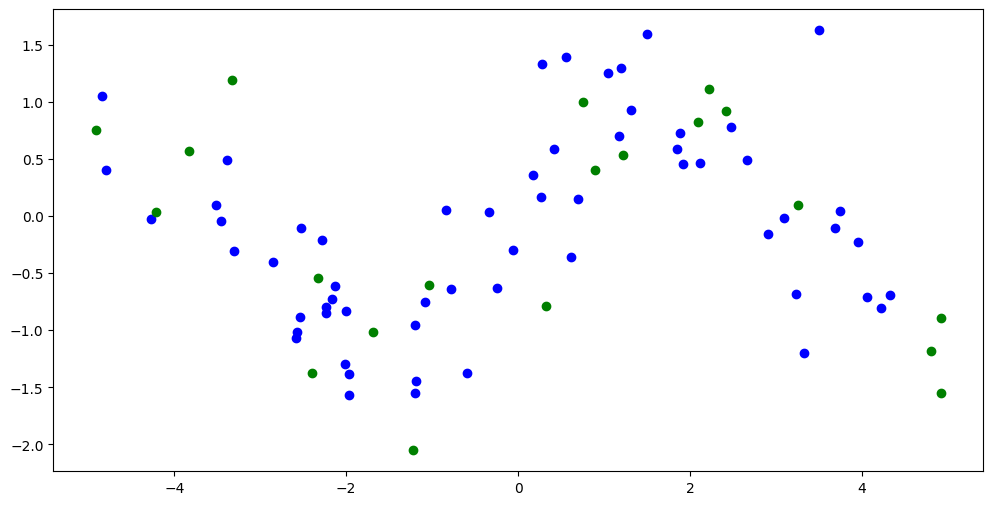

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data')
plt.scatter(X_test, y_test, color='green', label='Test Data')

### Plot the predictions

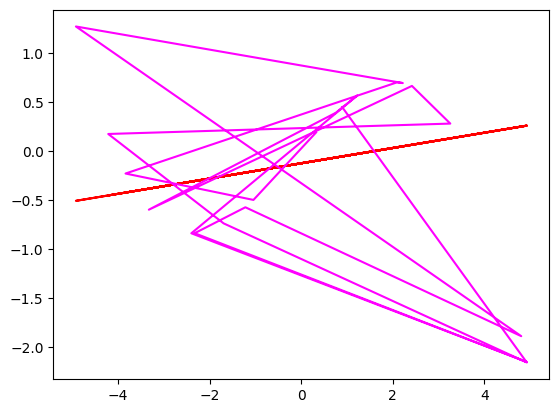

In [12]:
plt.plot(X_test, y_pred_test_linear, color='red', linestyle='-', label='Linear Regression Prediction')
plt.plot(X_test, y_pred_test_poly, color='magenta', linestyle='-', label='Polynomial Regression Prediction')

### Plot the prediction intervals

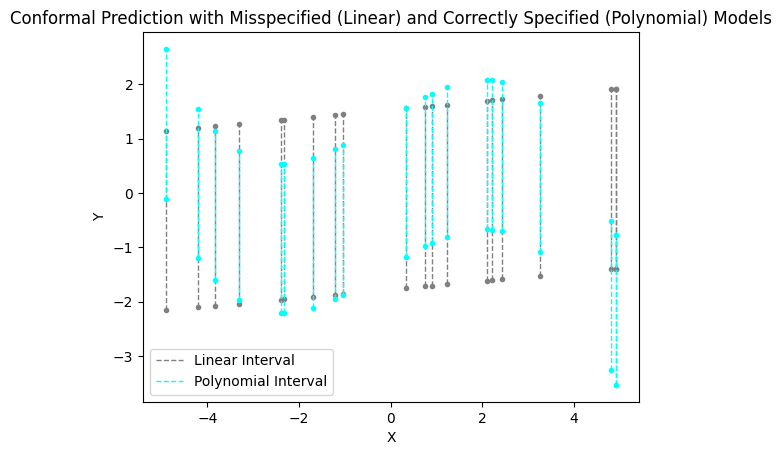

In [13]:
for i, (lower_linear, upper_linear) in enumerate(prediction_intervals_linear):
    plt.plot([X_test[i], X_test[i]], [lower_linear, upper_linear], color='gray', linestyle='--', linewidth=1, label='Linear Interval' if i == 0 else "")
    plt.plot(X_test[i], lower_linear, 'o', color='gray', markersize=3)  # Show lower bound
    plt.plot(X_test[i], upper_linear, 'o', color='gray', markersize=3)  # Show upper bound

for i, (lower_poly, upper_poly) in enumerate(prediction_intervals_poly):
    plt.plot([X_test[i], X_test[i]], [lower_poly, upper_poly], color='cyan', linestyle='--', linewidth=1, label='Polynomial Interval' if i == 0 else "")
    plt.plot(X_test[i], lower_poly, 'o', color='cyan', markersize=3)  # Show lower bound
    plt.plot(X_test[i], upper_poly, 'o', color='cyan', markersize=3)  # Show upper bound

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Conformal Prediction with Misspecified (Linear) and Correctly Specified (Polynomial) Models')
plt.legend()
plt.show()

### Calculate MSE

In [14]:
mse_linear = mean_squared_error(y_test, y_pred_test_linear)
mse_poly = mean_squared_error(y_test, y_pred_test_poly)
print(f"Linear Model Mean Squared Error: {mse_linear:.3f}")
print(f"Polynomial Model Mean Squared Error: {mse_poly:.3f}")

Linear Model Mean Squared Error: 1.092
Polynomial Model Mean Squared Error: 0.542


# Conclusion

This notebook clearly demonstrates the impact of model misspecification on conformal prediction.  While conformal prediction guarantees coverage even with a misspecified model, the efficiency of the prediction intervals suffers.  Specifically, we see that:The correctly specified model (polynomial regression) produces narrower prediction intervals, indicating more precise uncertainty estimates.The misspecified model (linear regression) produces wider intervals, reflecting the higher uncertainty due to the model's inability to capture the underlying data generating process.The Mean Squared Error (MSE) is significantly lower for the polynomial regression model, confirming that it provides a better fit to the data.Therefore, while conformal prediction is robust to model misspecification in terms of coverage, it is crucial to use a well-specified model to obtain more informative and useful prediction intervals.  In practical applications, this highlights the importance of careful model selection and validation.